In [2]:
import matplotlib.pyplot as plt
# os.chdir('/pfs/data6/home/ma/ma_ma/ma_kreffert/Probabilistic_LTSF/notebooks/BasicTS/')
from utils import init, get_predictions, validate, load_data
import os
os.chdir('/home/kreffert/Probabilistic_LTSF/BasicTS/')
from basicts.data import TimeSeriesForecastingDataset
from basicts.utils import get_regular_settings

data_sets = load_data()

Validation dataset is too short, enabling overlap. See details in /home/kreffert/Probabilistic_LTSF/BasicTS/basicts/data/simple_tsf_dataset.py at line 96.
Training dataset is too short, enabling overlap. See details in /home/kreffert/Probabilistic_LTSF/BasicTS/basicts/data/simple_tsf_dataset.py at line 96.
Validation dataset is too short, enabling overlap. See details in /home/kreffert/Probabilistic_LTSF/BasicTS/basicts/data/simple_tsf_dataset.py at line 96.
Test dataset is too short, enabling overlap. See details in /home/kreffert/Probabilistic_LTSF/BasicTS/basicts/data/simple_tsf_dataset.py at line 96.


20


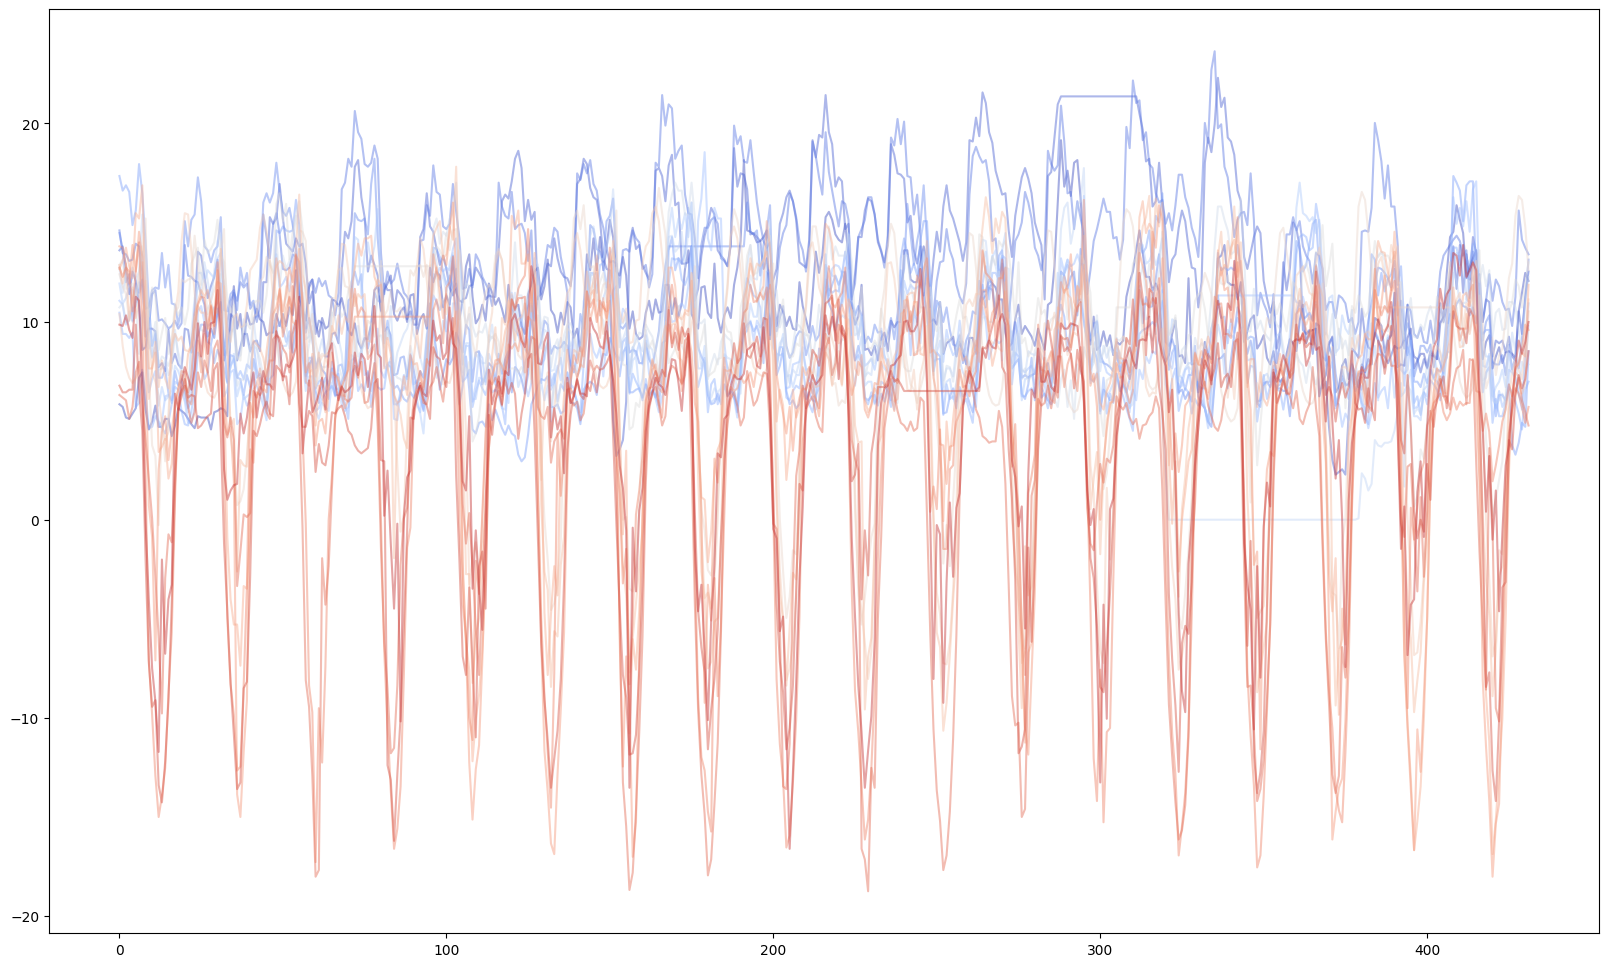

In [17]:
data = data_sets["ETTh1"]["train"]
length = 96*2 #96+96# 720 # train_sets[0].data.shape[0]
input_length = 96
output_length =336

moving_window = False
if moving_window:
    length = input_length
    offset = output_length
else:
    length = input_length + output_length
    offset = 0
max_series = int(data.data.shape[0]/length)
print(max_series)
cmap = plt.cm.coolwarm
plt.figure(figsize=(20, 12))
for l in range(max_series):
    start = length * l
    end = start + length + offset
    if end > data.data.shape[0]:  # Skip if out-of-bounds
        continue
    color = cmap(l / max_series)
    plt.plot(range(length + offset), data.data[start:end, 0, 0], color=color, alpha=9*(1/max_series))
plt.show()

# for l in range(max_series):# older series in red
#     color = cmap((max_series - l) / max_series)
#     plt.plot(range(length), data.data[length * l:length * (l + 1), 0, 0], color=color, alpha=0.3)
# plt.show()

In [29]:
import torch
def create_data(input_tensor, input_length=96, output_length=720, moving_window=False):
    '''Create non overlapping prediction windows.'''
    length = input_length+output_length
    if moving_window:
        length = input_length
        offset = output_length
    else:
        length = input_length + output_length
        offset = 0
    max_series = int(input_tensor.shape[0]/(length))
    inputs, targets = [], []
    for l in range(max_series):
        start = length * l
        midpoint = start + length
        end = start + length + offset
        if end > input_tensor.shape[0]:  # Skip if out-of-bounds
            continue
        inputs.append(torch.tensor(input_tensor[start:midpoint, :, 0]))
        targets.append(torch.tensor(input_tensor[midpoint:end, :, 0]))
    
    return {'inputs':torch.stack(inputs, dim=0), 'target': torch.stack(targets, dim=0)}
data = create_data(data_sets["ETTm1"]["train"].data, input_length=96, output_length=96, moving_window=True)
all_inputs, all_targets = data['inputs'], data['target']
print(all_inputs.shape)

torch.Size([359, 96, 7])


In [29]:
import torch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from tqdm import tqdm

def cluster_by_last_dim(
    tensor: torch.Tensor,
    n_clusters: int = 10,
    metric: str = "cosine",
    return_rankings: bool = False,
    reference_idx: int = 0,
):
    """
    Cluster tensor elements independently for each dimension in the last axis.

    Args:
        tensor: Input tensor of shape [N, M, D] (e.g., [7825, 96, 7]).
        n_clusters: Number of clusters to compute (default: 10).
        metric: Similarity metric ("cosine" or "euclidean").
        return_rankings: If True, returns similarity rankings for a reference.
        reference_idx: Index of reference element for rankings (default: 0).

    Returns:
        If return_rankings=False:
            Dict {dim_i: cluster_labels} where cluster_labels is array[N].
        If return_rankings=True:
            Dict {dim_i: ranked_indices} where ranked_indices is array[N].
    """
    # Convert tensor to numpy if needed
    if isinstance(tensor, torch.Tensor):
        data = tensor.numpy()
    else:
        data = tensor

    results = {}

    for i in range(data.shape[-1]):  # Iterate over last dimension (D=7)
        slice_i = data[:, :, i]  # Shape [N, M]

        if return_rankings:
            # Compute similarity rankings for reference element
            if metric == "cosine":
                sim = cosine_similarity(slice_i[reference_idx : reference_idx + 1], slice_i)[0]
            elif metric == "euclidean":
                dist = np.linalg.norm(slice_i - slice_i[reference_idx], axis=1)
                sim = -dist  # Convert distance to "similarity" (higher = closer)
            else:
                raise ValueError(f"Unsupported metric: {metric}")

            ranked_indices = np.argsort(-sim)  # Descending order
            results[f"dim_{i}"] = ranked_indices

        else:
            # Perform clustering
            if metric == "cosine":
                # Normalize for cosine KMeans (optional but recommended)
                norms = np.linalg.norm(slice_i, axis=1, keepdims=True)
                normalized = slice_i / np.where(norms == 0, 1e-10, norms)
                kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                cluster_labels = kmeans.fit_predict(normalized)
            elif metric == "euclidean":
                kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                cluster_labels = kmeans.fit_predict(slice_i)
            else:
                raise ValueError(f"Unsupported metric: {metric}")

            results[f"dim_{i}"] = cluster_labels

    return results
def analyze_similarity(
    tensor: torch.Tensor,
    n_clusters: int = 10,
    metric: str = "cosine",
    top_k_pairs: int = 10,
    return_clusters: bool = True,
    return_ranked_pairs: bool = True,
):
    """
    Analyze similarity across the last dimension of a tensor, with options for clustering and pairwise rankings.

    Args:
        tensor: Input tensor of shape [N, M, D] (e.g., [7825, 96, 7]).
        n_clusters: Number of clusters (if return_clusters=True).
        metric: "cosine" or "euclidean".
        top_k_pairs: Number of top similar pairs to return (if return_ranked_pairs=True).
        return_clusters: If True, returns cluster labels for each dimension.
        return_ranked_pairs: If True, returns top similar pairs for each dimension.

    Returns:
        Dict with keys:
            - "clusters": Dict {dim_i: cluster_labels} (if return_clusters=True).
            - "ranked_pairs": Dict {dim_i: [(score, (idx_a, idx_b)), ...]} (if return_ranked_pairs=True).
    """
    if isinstance(tensor, torch.Tensor):
        data = tensor.numpy()
    else:
        data = tensor

    results = {}
    if return_clusters:
        results["clusters"] = {}
    if return_ranked_pairs:
        results["ranked_pairs"] = {}

    for i in tqdm(range(data.shape[-1]), desc="Clustering"):
        slice_i = data[:, :, i]  # Shape [N, M]

        # --- Clustering ---
        if return_clusters:
            if metric == "cosine":
                norms = np.linalg.norm(slice_i, axis=1, keepdims=True)
                normalized = slice_i / np.where(norms == 0, 1e-10, norms)
                kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                cluster_labels = kmeans.fit_predict(normalized)
            elif metric == "euclidean":
                kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                cluster_labels = kmeans.fit_predict(slice_i)
            else:
                raise ValueError(f"Unsupported metric: {metric}")
            results["clusters"][f"dim_{i}"] = cluster_labels

        # --- Pairwise Similarity Rankings ---
        if return_ranked_pairs:
            if metric == "cosine":
                sim_matrix = cosine_similarity(slice_i)  # Shape [N, N]
                # Ignore self-similarity (diagonal)
                np.fill_diagonal(sim_matrix, -np.inf)
            elif metric == "euclidean":
                dist_matrix = euclidean_distances(slice_i)
                sim_matrix = -dist_matrix  # Convert to "similarity" (higher = closer)
                np.fill_diagonal(sim_matrix, -np.inf)
            else:
                raise ValueError(f"Unsupported metric: {metric}")

            # Find top-k pairs
            flat_indices = np.argsort(sim_matrix.ravel())[::-1][:top_k_pairs]
            pairs = np.unravel_index(flat_indices, sim_matrix.shape)
            ranked_pairs = [
                (sim_matrix[pairs[0][k], pairs[1][k]], (pairs[0][k], pairs[1][k]))
                for k in range(top_k_pairs)
            ]
            results["ranked_pairs"][f"dim_{i}"] = ranked_pairs

    return results

torch.Size([352, 96, 7])


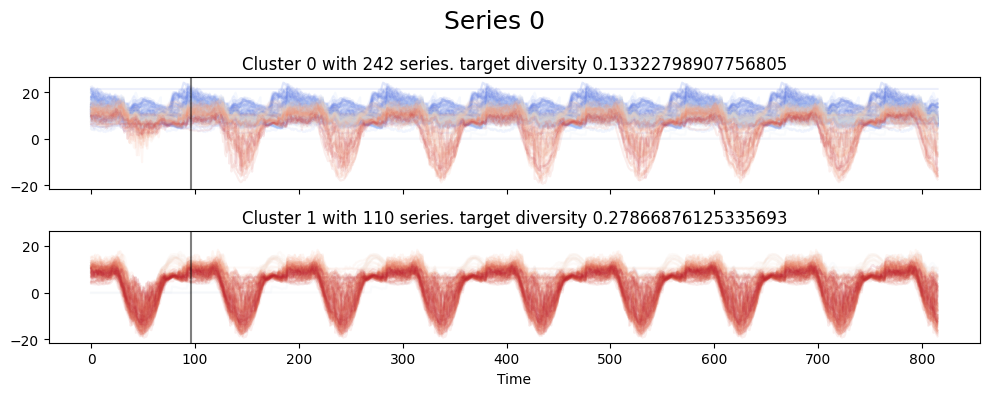

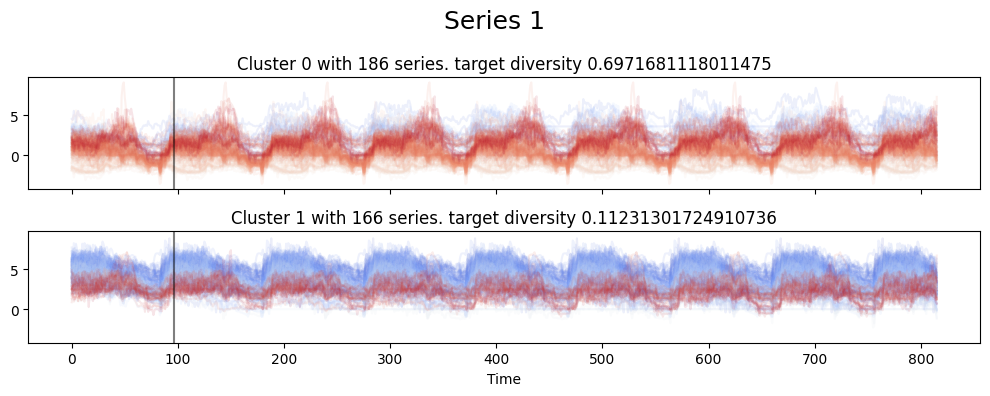

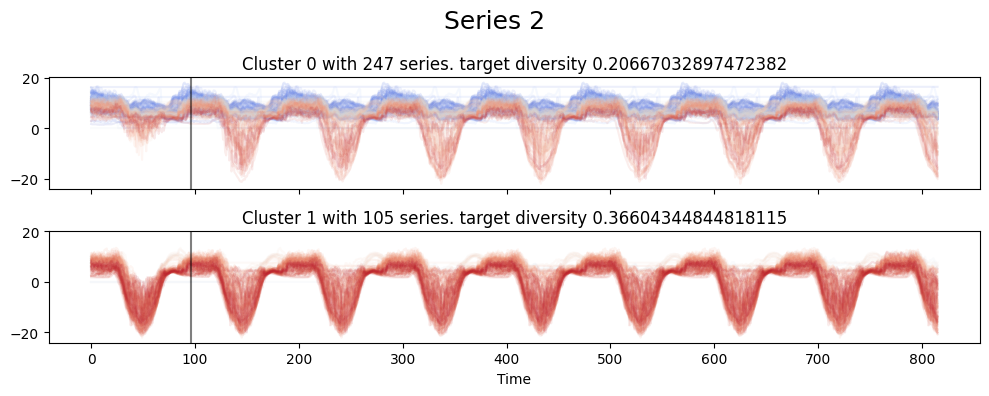

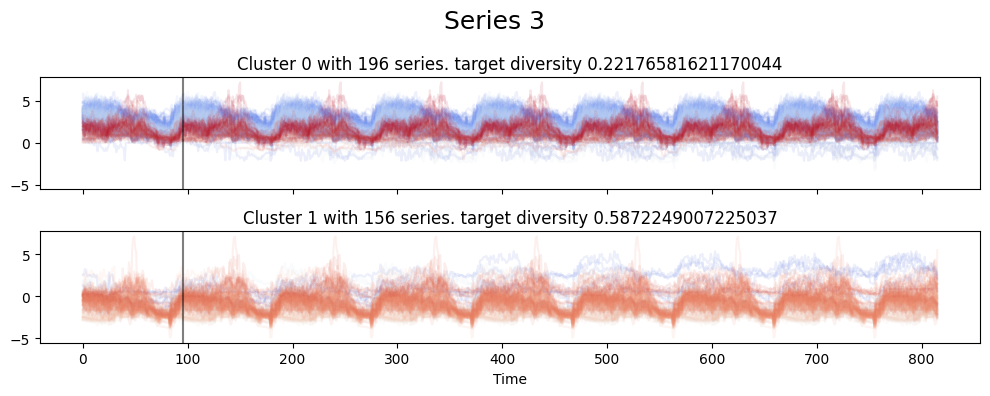

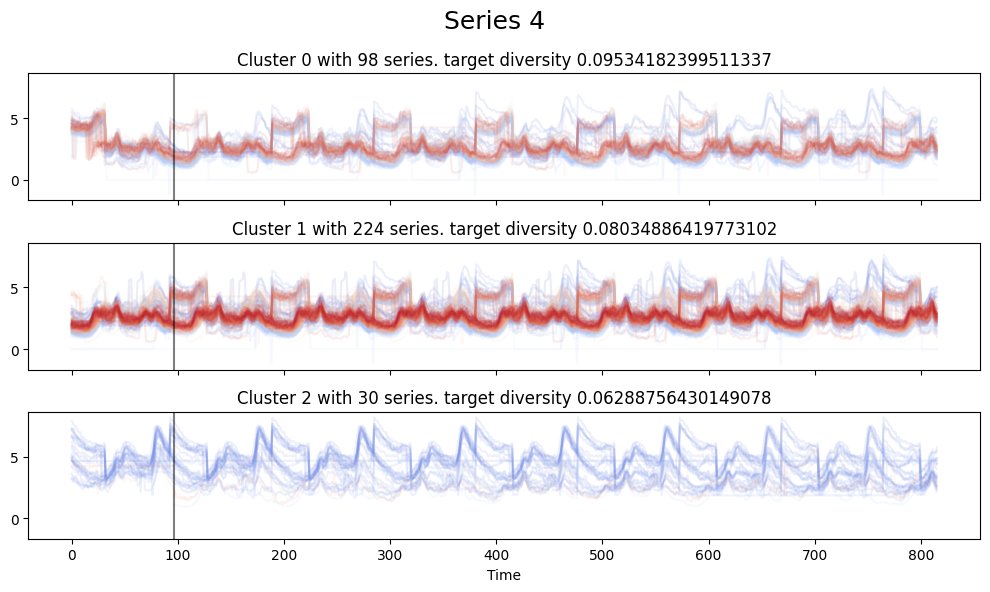

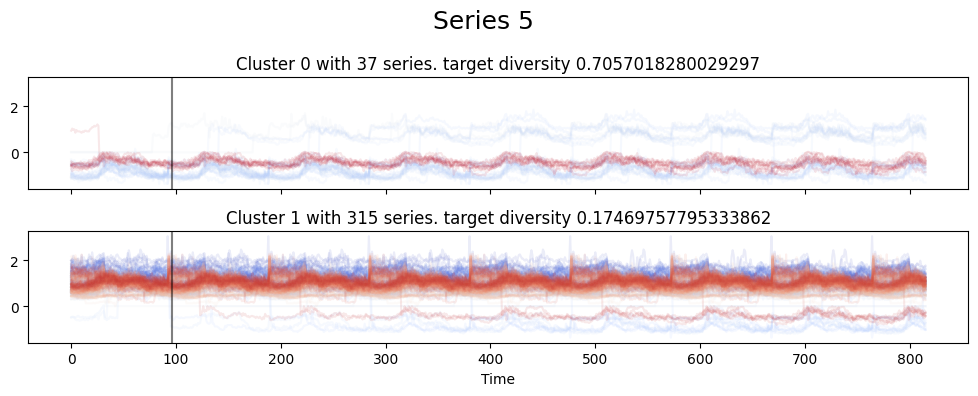

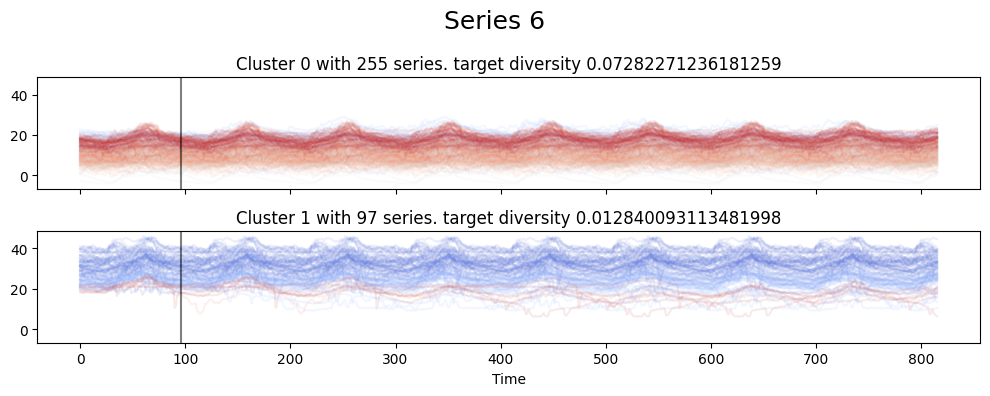

In [41]:
import torch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances
from tslearn.metrics import cdist_dtw
from scipy.fft import fft

def autocorr_distance(X, lag=20):
    def acf(x):
        x = (x - np.mean(x)) / (np.std(x) + 1e-10)
        return np.correlate(x, x, mode='full')[len(x)-1:] / len(x)
    acfs = np.array([acf(x)[:lag] for x in X])
    return pairwise_distances(acfs, metric="euclidean")

def fourier_distance(X, n_coeffs=20):
    fft_features = np.abs(fft(X))[:, :n_coeffs]
    return pairwise_distances(fft_features, metric="euclidean")

def compute_distance_matrix(X, metric):
    if metric == "euclidean" or metric == "cosine":
        return pairwise_distances(X, metric=metric)
    elif metric == "dtw":
        return cdist_dtw(X)
    elif metric == "autocorr":
        return autocorr_distance(X)
    elif metric == "fourier":
        return fourier_distance(X)
    else:
        raise ValueError(f"Unsupported metric: {metric}")

def cluster_by_last_dim(
    tensor: torch.Tensor,
    targets: torch.Tensor,
    n_clusters: int = None,
    metric: str = "cosine",
    return_rankings: bool = False,
    reference_idx: int = 0,
    max_clusters: int = 10,
    diversity_metric: str = "cosine"
):
    if isinstance(tensor, torch.Tensor):
        data = tensor.numpy()
    if isinstance(targets, torch.Tensor):
        targets = targets.numpy()

    results = {}

    for i in range(data.shape[-1]):
        slice_i = data[:, :, i]
        target_i = targets[:, :, i]

        if return_rankings:
            dist_matrix = compute_distance_matrix(slice_i, metric)
            sim = -dist_matrix[reference_idx]
            results[f"dim_{i}"] = np.argsort(-sim)
        else:
            # Optional: normalize if cosine
            if metric == "cosine":
                norms = np.linalg.norm(slice_i, axis=1, keepdims=True)
                X = slice_i / (norms + 1e-10)
            else:
                X = slice_i

            if metric in ["dtw", "autocorr", "fourier"]:
                # Use precomputed distance matrix with KMeans is not supported directly.
                # Instead, use distance matrix for diversity only.
                X_kmeans = slice_i
            else:
                X_kmeans = X

            if n_clusters is None:
                best_score = -1
                best_k = 2
                for k in range(2, max_clusters + 1):
                    try:
                        kmeans = KMeans(n_clusters=k, random_state=42).fit(X_kmeans)
                        score = silhouette_score(X_kmeans, kmeans.labels_)
                        if score > best_score:
                            best_score = score
                            best_k = k
                    except:
                        continue
                n = best_k
            else:
                n = n_clusters

            kmeans = KMeans(n_clusters=n, random_state=42).fit(X_kmeans)
            labels = kmeans.labels_
            results[f"dim_{i}"] = labels

            # Compute diversity in targets
            cluster_diversity = {}
            for c in np.unique(labels):
                indices = np.where(labels == c)[0]
                if len(indices) > 1:
                    pairwise_dists = compute_distance_matrix(target_i[indices], diversity_metric)
                    avg_dist = np.mean(pairwise_dists)
                else:
                    avg_dist = 0
                cluster_diversity[f"cluster_{c}"] = avg_dist
            results[f"dim_{i}_diversity"] = cluster_diversity

    return results




from collections import Counter
# "ETTh1", "ETTh2", "ETTm1", "ETTm2", "Traffic", "Weather", "ExchangeRate", "Illness"
input_length, output_length = 96, 720 #144
data = create_data(data_sets["ETTm1"]["train"].data, input_length=input_length, output_length=output_length, moving_window=True)
all_inputs, all_targets = data['inputs'], data['target']
print(all_inputs.shape)
results = cluster_by_last_dim(
    all_inputs,
    all_targets,
    metric="fourier",
)
for dim in range(min(7, all_inputs.shape[-1])):
    clusters = results[f'dim_{dim}']
    num_clusters = max(clusters) + 1
    colors = ['red', 'green', 'blue', 'black', 'grey', 'purple', 'orange']
    
    fig, axes = plt.subplots(num_clusters, 1, figsize=(10, 2 * num_clusters), sharex=True, sharey=True)
    num_lines = all_inputs.shape[0]
    for i in range(num_clusters):
        ax = axes[i]
        indices = np.where(clusters == i)[0]
        for j in indices:
            color = cmap(j / num_lines)
            ax.plot(range(all_inputs.shape[1]), all_inputs[j, :, dim], color=color, alpha=0.1)#colors[i % len(colors)], alpha=0.1)
            ax.plot(range(all_inputs.shape[1], all_inputs.shape[1]+output_length), all_targets[j, :output_length, dim], color=color, alpha=0.1)#color=colors[i % len(colors)], alpha=0.1)
        ax.set_title(f'Cluster {i} with {len(indices)} series. target diversity {results[f"dim_{dim}_diversity"][f"cluster_{i}"]}')
        ax.axvline(all_inputs.shape[1], color='black', alpha=0.5)
    
    plt.xlabel('Time')
    fig.suptitle(f"Series {dim}", fontsize=18)
    plt.tight_layout()
    plt.show()

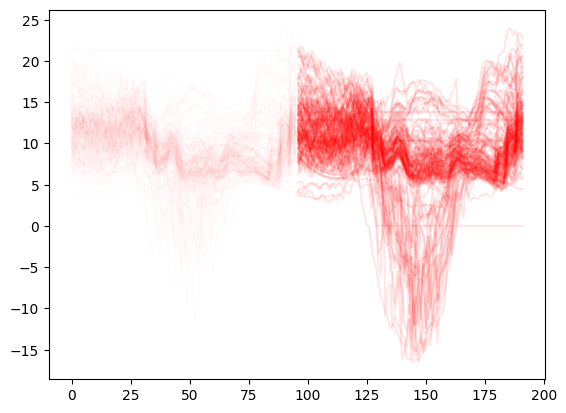

In [67]:
#clusters.index(clusters == i)
dim = 0
clusters = results[f'dim_{0}']#['clusters'][f'dim_{0}']
colors = ['red', 'green', 'blue', 'black', 'grey', 'purple', 'black']
cluster = 0
for i in range(max(clusters)):
    for j in range(len(np.where(clusters == i)[0])):
        # print(all_inputs[np.where(clusters == i)[0][j], :, dim, 0].shape)
        idx = np.where(clusters == i)[0][j]
        plt.plot(range(all_inputs.shape[1]), all_inputs[idx, :, dim], color=colors[i], label=f'cluster {i}', alpha=0.01)
        plt.plot(range(all_inputs.shape[1], all_inputs.shape[1]+96), all_targets[np.where(clusters == i)[0][j], :96, dim], color=colors[i], label=f'cluster {i}', alpha=0.1)

# plt.legend()
plt.show()

In [ ]:
from easytorch.core.data_loader import build_data_loader
params = {
    'BATCH_SIZE':64,
    'SHUFFLE': False,
}
dataloader = build_data_loader(train_sets[0], params)
all_inputs = []
all_targets = []

for i, l in enumerate(dataloader):
    all_inputs.append(l['inputs'])
    all_targets.append(l['target'])

# Stack along the batch dimension
all_inputs = torch.cat(all_inputs, dim=0)
all_targets = torch.cat(all_targets, dim=0)

In [ ]:
from easytorch.core.data_loader import build_data_loader
params = {
    'BATCH_SIZE':64,
    'SHUFFLE': False,
    'INTERVAL': 1,
}
dataloader = build_data_loader(val_sets[0], params)
all_inputs = []

for i, l in enumerate(dataloader):
    all_inputs.append(l['inputs'])

# Stack along the batch dimension
all_inputs = torch.cat(all_inputs, dim=0)

# Input tensor: [7825, 96, 7]
results = analyze_similarity(
    all_inputs[..., 0],
    n_clusters=10,
    metric="euclidean",
    top_k_pairs=5,
    return_clusters=True,
    return_ranked_pairs=True,
)

# Get cluster assignments for dimension 0
print(results["clusters"]["dim_0"])  # Shape [7825]

# Get top 5 most similar pairs for dimension 0
print(results["ranked_pairs"]["dim_0"])
# Output: [(0.98, (123, 456)), (0.97, (789, 1011)), ...]

In [ ]:
#clusters.index(clusters == i)
dim = 0
clusters = results['clusters'][f'dim_{0}']
colors = ['red', 'green', 'blue', 'yellow', 'grey', 'purple', 'black']
cluster = 0
for i in range(cluster, cluster+3):#max(clusters)):
    for j in range(3):#len(np.where(clusters == i)[0])):
        # print(all_inputs[np.where(clusters == i)[0][j], :, dim, 0].shape)
        idx = np.where(clusters == i)[0][j]
        plt.plot(range(all_inputs.shape[1]), all_inputs[idx, :, dim, 0], color=colors[i], label=f'cluster {i}', alpha=0.3)
        plt.plot(range(all_inputs.shape[1], all_inputs.shape[1]+96), all_targets[np.where(clusters == i)[0][j], :96, dim, 0], color=colors[i], label=f'cluster {i}', alpha=0.3)
# plt.legend()
plt.show()

In [10]:


# Input tensor: [7825, 96, 7]
results = analyze_similarity(
    all_inputs[..., 0],
    n_clusters=10,
    metric="euclidean",
    top_k_pairs=5,
    return_clusters=True,
    return_ranked_pairs=True,
)

# Get cluster assignments for dimension 0
print(results["clusters"]["dim_0"])  # Shape [7825]

# Get top 5 most similar pairs for dimension 0
print(results["ranked_pairs"]["dim_0"])
# Output: [(0.98, (123, 456)), (0.97, (789, 1011)), ...]

Clustering:   0%|                                                                                       | 0/96 [00:00<?, ?it/s]


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
print(results) 
#clusters.index(clusters == i)
dim = 0
clusters = results['clusters'][f'dim_{0}']
colors = ['red', 'green', 'blue', 'yellow', 'grey', 'purple', 'black']
cluster = 2
for i in range(cluster, cluster+1):#max(clusters)):
    for j in range(10):
        print(all_inputs[np.where(clusters == i)[0], :, dim, 0].shape)
        plt.plot(range(all_inputs.shape[1]), all_inputs[np.where(clusters == i)[0], :, dim][j], color=colors[i], label=f'cluster {i}', alpha=0.3)
plt.show()

In [ ]:
import torch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

def cluster_by_last_dim(
    tensor: torch.Tensor,
    n_clusters: int = 10,
    metric: str = "cosine",
    return_rankings: bool = False,
    reference_idx: int = 0,
):
    """
    Cluster tensor elements independently for each dimension in the last axis.

    Args:
        tensor: Input tensor of shape [N, M, D] (e.g., [7825, 96, 7]).
        n_clusters: Number of clusters to compute (default: 10).
        metric: Similarity metric ("cosine" or "euclidean").
        return_rankings: If True, returns similarity rankings for a reference.
        reference_idx: Index of reference element for rankings (default: 0).

    Returns:
        If return_rankings=False:
            Dict {dim_i: cluster_labels} where cluster_labels is array[N].
        If return_rankings=True:
            Dict {dim_i: ranked_indices} where ranked_indices is array[N].
    """
    # Convert tensor to numpy if needed
    if isinstance(tensor, torch.Tensor):
        data = tensor.numpy()
    else:
        data = tensor

    results = {}

    for i in range(data.shape[-1]):  # Iterate over last dimension (D=7)
        slice_i = data[:, :, i]  # Shape [N, M]

        if return_rankings:
            # Compute similarity rankings for reference element
            if metric == "cosine":
                sim = cosine_similarity(slice_i[reference_idx : reference_idx + 1], slice_i)[0]
            elif metric == "euclidean":
                dist = np.linalg.norm(slice_i - slice_i[reference_idx], axis=1)
                sim = -dist  # Convert distance to "similarity" (higher = closer)
            else:
                raise ValueError(f"Unsupported metric: {metric}")

            ranked_indices = np.argsort(-sim)  # Descending order
            results[f"dim_{i}"] = ranked_indices

        else:
            # Perform clustering
            if metric == "cosine":
                # Normalize for cosine KMeans (optional but recommended)
                norms = np.linalg.norm(slice_i, axis=1, keepdims=True)
                normalized = slice_i / np.where(norms == 0, 1e-10, norms)
                kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                cluster_labels = kmeans.fit_predict(normalized)
            elif metric == "euclidean":
                kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                cluster_labels = kmeans.fit_predict(slice_i)
            else:
                raise ValueError(f"Unsupported metric: {metric}")

            results[f"dim_{i}"] = cluster_labels

    return results

# Assuming your tensor is named `data_tensor` with shape [7825, 96, 7]
cluster_labels = cluster_by_last_dim(
    all_inputs[..., 0],
    n_clusters=10,
    metric="cosine",
    return_rankings=False,
)

# Access cluster assignments for dimension 0:
print(cluster_labels["dim_0"])  # Shape [7825]

    
# rankings = cluster_by_last_dim(
#     all_inputs[..., 0],
#     metric="cosine",
#     return_rankings=True,
#     reference_idx=0,  # Rank by similarity to the 0th element
# )

# # Access rankings for dimension 0:
# print(rankings["dim_0"])  # Indices sorted by similarity to reference

In [ ]:
# my = torch.tensor()
# for i, b in enumerate(dataloader):
#     print(i)
#     print(b['inputs'].shape)
#     print(b['target'].shape)
#     my = torch.stack(b['inputs'], )

all_inputs = []

for i, l in enumerate(dataloader):
    all_inputs.append(l['inputs'])

# Stack along the batch dimension
all_inputs = torch.cat(all_inputs, dim=0)

In [ ]:
print(all_inputs.shape)

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics.pairwise import pairwise_distances
from tqdm import tqdm

def find_most_similar_series(dataloader, distance_metric='euclidean', top_k=5):
    """
    Find the most similar time series prefixes across all batches in a dataloader.
    Handles variable batch sizes by normalizing each series independently.
    
    Args:
        dataloader: PyTorch DataLoader yielding batches of shape [batch_size, time_steps, num_series]
        distance_metric: Distance metric to use ('euclidean', 'cosine', etc.)
        top_k: Number of most similar pairs to return
        
    Returns:
        List of tuples containing (distance, (batch_idx1, series_idx1), (batch_idx2, series_idx2))
    """
    
    # Collect all prefixes and their metadata
    all_prefixes = []
    metadata = []  # Stores (batch_idx, series_idx) for each prefix
    
    # Process all batches
    for batch_idx, batch in enumerate(tqdm(dataloader, desc="Processing batches")):
        batch = batch['inputs'][..., 0]  # Extract the input tensor
            
        batch_size, time_steps, num_series = batch.shape
        
        # For each series in this batch, collect its time steps
        for series_idx in range(num_series):
            # Take all time steps for this series
            # Shape will be [batch_size, time_steps]
            prefix = batch[:, :, series_idx]
            
            # We'll normalize by batch size to make comparable across batches
            # Compute mean and std for this series in this batch
            mean = prefix.mean()
            std = prefix.std()
            
            # Normalize (avoid division by zero)
            if std > 0:
                normalized_prefix = (prefix - mean) / std
            else:
                normalized_prefix = prefix - mean
                
            # Flatten to 1D vector
            flattened = normalized_prefix.reshape(-1).numpy()
            all_prefixes.append(flattened)
            metadata.append((batch_idx, series_idx))
    
    # Now we need to handle variable lengths - we'll use the minimum length
    min_length = min(len(p) for p in all_prefixes)
    
    # Truncate all prefixes to the minimum length
    truncated_prefixes = [p[:min_length] for p in all_prefixes]
    
    # Convert to numpy array for distance computation
    all_prefixes = np.array(truncated_prefixes)  # Shape: [total_series, min_length]
    
    # Compute pairwise distances
    dist_matrix = pairwise_distances(all_prefixes, metric=distance_metric)
    
    # Ignore self-distances by setting them to infinity
    np.fill_diagonal(dist_matrix, np.inf)
    
    # Find the top_k smallest distances
    flat_indices = np.argpartition(dist_matrix.ravel(), top_k)[:top_k]
    row_indices, col_indices = np.unravel_index(flat_indices, dist_matrix.shape)
    
    # Collect results
    results = []
    for row, col in zip(row_indices, col_indices):
        dist = dist_matrix[row, col]
        batch_series1 = metadata[row]
        batch_series2 = metadata[col]
        results.append((dist, batch_series1, batch_series2))
    
    # Sort by distance (ascending)
    results.sort(key=lambda x: x[0])
    
    return results[:top_k]

In [ ]:
# Assuming you have a DataLoader called 'train_loader'
similar_pairs = find_most_similar_series(dataloader, distance_metric='euclidean', top_k=5)

# Print results
for dist, (batch1, series1), (batch2, series2) in similar_pairs:
    print(f"Distance: {dist:.4f}")
    print(f"Series 1: Batch {batch1}, Series {series1}")
    print(f"Series 2: Batch {batch2}, Series {series2}")
    print("-" * 40)

# OLD

In [ ]:
import matplotlib.pyplot as plt
# os.chdir('/pfs/data6/home/ma/ma_ma/ma_kreffert/Probabilistic_LTSF/notebooks/BasicTS/')
from utils import init, get_predictions, validate
import os
os.chdir('/home/kreffert/Probabilistic_LTSF/BasicTS/')
# os.chdir('/pfs/data6/home/ma/ma_ma/ma_kreffert/Probabilistic_LTSF/BasicTS/')
from prob.prob_head import ProbabilisticHead
path= '6f0ff289427f26b39444d02254fe169c'#'27d40957374f98d2d16be997f2c114de'
cfg_path = "final_weights/PatchTST/univariate/ETTh1_prob.py" #ETTh1_96_720/a8de06edad7530010e0b704422b431a2/ETTh1_prob.py"
# /pfs/data6/home/ma/ma_ma/ma_kreffert/
path = "Probabilistic_LTSF/BasicTS/final_weights/PatchTST/univariate/ETTh1_100_96_720/a8de06edad7530010e0b704422b431a2/PatchTST_best_val_NLL.pt"
# path = "Probabilistic_LTSF/BasicTS/final_weights/PatchTST/univariate/ETTh1_96_720/4230f7020ba7029f40537557a2f908307/"

runner, cfg = init(model='PatchTST', dataset='ETTh1', path=path, no_logging=False, cfg_path=cfg_path, set_rescale=False)
validate(runner, cfg=cfg, train_epoch=None)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import logging
from tqdm import tqdm
from scipy.stats import norm
no_logging=True
if no_logging:
    logging.disable(logging.CRITICAL)  # Temporarily disable all logging
#print("This will print, but logs are disabled")

# Run a baseline model in BasicTS framework.
# pylint: disable=wrong-import-position
import os
import sys
from argparse import ArgumentParser

__file__ = "/home/kreffert/Probabilistic_LTSF/BasicTS/experiments/train.py"
sys.path.append(os.path.abspath(__file__ + '/../..'))
os.chdir(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
sys.argv = [__file__]

import torch
import basicts
from easytorch.utils import set_visible_devices, get_logger
from easytorch.config import init_cfg

torch.set_num_threads(4) # avoid high cpu avg usage
model='PatchTST'
dataset='ETTh1_prob'
def parse_args():
    parser = ArgumentParser(description='Run time series forecasting model in BasicTS framework!')
    parser.add_argument('-c', '--cfg', default=f'baselines/{model}/{dataset}.py ', help='training config')
    parser.add_argument('-g', '--gpus', default='0', help='visible gpus')
    return parser.parse_args()

args = parse_args()

cfg = init_cfg(args.cfg, save=True)

logger = get_logger('easytorch-launcher')
logger.info('Initializing runner "{}"'.format(cfg['RUNNER']))
runner = cfg['RUNNER'](cfg)
runner.init_logger(logger_name='easytorch-training', log_file_name='training_log')
runner.init_training(cfg)
# Your function code here...
if no_logging:
    logging.disable(logging.NOTSET)  # Re-enable logging
train = runner.build_train_dataset(cfg)

In [ ]:
from basicts.data import TimeSeriesForecastingDataset
from basicts.utils import get_regular_settings

DATA_NAME = 'ETTh1'
train_sets, val_sets, test_sets = [], [], []
for DATA_NAME in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "Traffic", "Weather", "ExchangeRate", "Illness"]:
    regular_settings = get_regular_settings(DATA_NAME)
    TRAIN_VAL_TEST_RATIO = regular_settings['TRAIN_VAL_TEST_RATIO']
    NORM_EACH_CHANNEL = True
    RESCALE = True
    NULL_VAL = regular_settings['NULL_VAL']
    params = {'dataset_name': DATA_NAME,
                'train_val_test_ratio': TRAIN_VAL_TEST_RATIO,
                'input_len': 96,
                'output_len': 720,
    }
    train_dataset = TimeSeriesForecastingDataset(mode='train', **params)
    val_dataset = TimeSeriesForecastingDataset(mode='valid', **params)
    test_dataset = TimeSeriesForecastingDataset(mode='test', **params)
    train_sets.append(train_dataset)
    val_sets.append(val_dataset)
    test_sets.append(test_dataset)

In [ ]:
import numpy as np
import plotly.graph_objects as go

def plot_autocorrelation(train_data):
    # Select the first feature (column) from train_data
    feature_idx = 0
    train_data = train.data  # Extract the first channel of the train dataset
    series = train_data[:, 0, feature_idx]
    print(series.shape)
    
    # Compute autocorrelation
    def autocorrelation(x, max_lag):
        x = x - np.mean(x)
        result = np.correlate(x, x, mode='full')
        result = result[result.size // 2:]  # Keep only second half
        result /= result[0]  # Normalize
        return result[:max_lag + 1]
    
    # Set max lag to, for example, 7 days of hourly data
    max_ag = 24 * 30 # 24 * x -> (4 -> 96), (14 -> 336), (30 -> 720)
    acf_values = autocorrelation(series, max_lag)
    
    # Plot using Plotly
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=np.arange(len(acf_values)),
        y=acf_values,
        name='Autocorrelation',
        marker_color='black'
    ))
    
    fig.update_layout(
        title='Autocorrelation of Train Data (Feature 1)',
        xaxis_title='Lag (hours)',
        yaxis_title='Autocorrelation',
        height=500,
        # xaxis=dict(tickmode='linear'),
        # yaxis=dict(range=[-1, 1])
    )
    
    fig.show()
for train in train_sets:
    plot_autocorrelation(train)

In [ ]:
import easytorch
train = runner.build_train_dataset(cfg)
loader = easytorch.core.data_loader.build_data_loader(train, cfg['TRAIN.DATA'])
print(train)
print(loader)

In [ ]:
import plotly.graph_objects as go
train = runner.build_train_dataset(cfg)
val = runner.build_val_dataset(cfg)
test = runner.build_test_dataset(cfg)
print(train.data.shape)
print(val.data.shape)
print(test.data.shape)

# Extract the first channel of each dataset
train_data = train.data[:, :, 0]  # Extract the first channel of the train dataset
val_data = val.data[:, :, 0]  # Extract the first channel of the val dataset
test_data = test.data[:, :, 0]  # Extract the first channel of the test dataset

# Define the length of a daily pattern (24 hours/points)
daily_length = 24*7

# Create a figure for the overlaid daily curves
fig = go.Figure()

feature_colors = ['red', 'purple', 'cyan', 'magenta', 'yellow', 'green', 'blue']

# Calculate how many complete days are in the train dataset
num_days = train_data.shape[0] // daily_length

# Plot each feature
for i in range(1):  # Loop through 7 features
    # Create a subplot for each feature
    for day in range(num_days):
        # Get data for the current day
        start_idx = day * daily_length
        end_idx = start_idx + daily_length
        day_data = train_data[start_idx:end_idx, i]
        
        # Plot the daily curve with low opacity
        fig.add_trace(go.Scatter(
            x=np.arange(daily_length),  # Hours of the day (0-23)
            y=day_data,
            mode='lines',
            name=f'Day {day+1}, Feature {i+1}',
            line=dict(color=feature_colors[i]),
            opacity=0.1,  # Low opacity for individual days
            showlegend=False
        ))
    
    # Calculate and plot the average daily curve for each feature
    avg_daily_curve = np.zeros(daily_length)
    for day in range(num_days):
        start_idx = day * daily_length
        end_idx = start_idx + daily_length
        avg_daily_curve += train_data[start_idx:end_idx, i]
    
    avg_daily_curve /= num_days
    
    # Add the average curve with full opacity
    fig.add_trace(go.Scatter(
        x=np.arange(daily_length),
        y=avg_daily_curve,
        mode='lines',
        name=f'Avg Feature {i+1}',
        line=dict(color=feature_colors[i], width=3),
        opacity=1.0  # Full opacity for average
    ))

# Update layout for better appearance
fig.update_layout(
    title="Daily Patterns in Train Dataset (24-hour periods)",
    xaxis_title="Hour of Day (0-23)",
    yaxis_title="Value",
    hovermode='x unified',
    height=800,
    legend=dict(title="Features"),
)

# Add x-axis labels for hours
fig.update_xaxes(
    tickvals=list(range(0, daily_length, 2)),  # Show tick marks every 2 hours
    ticktext=[f"{h}:00" for h in range(0, daily_length, 2)]  # Format as hours
)

# Show the interactive plot
fig.show()

In [ ]:
import numpy as np
import plotly.graph_objects as go

# Select the first feature (column) from train_data
feature_idx = 0
series = train_data[:, feature_idx]

# Compute autocorrelation
def autocorrelation(x, max_lag):
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full')
    result = result[result.size // 2:]  # Keep only second half
    result /= result[0]  # Normalize
    return result[:max_lag + 1]

# Set max lag to, for example, 7 days of hourly data
max_ag = 24 * 30 # 24 * x -> (4 -> 96), (14 -> 336), (30 -> 720)
acf_values = autocorrelation(series, max_lag)

# Plot using Plotly
fig = go.Figure()
fig.add_trace(go.Bar(
    x=np.arange(len(acf_values)),
    y=acf_values,
    name='Autocorrelation',
    marker_color='black'
))

fig.update_layout(
    title='Autocorrelation of Train Data (Feature 1)',
    xaxis_title='Lag (hours)',
    yaxis_title='Autocorrelation',
    height=500,
    # xaxis=dict(tickmode='linear'),
    # yaxis=dict(range=[-1, 1])
)

fig.show()
